In [1]:
from detect_code.detect3 import load_model, predict
# mobilenet_v3_ssd320_voc0712.yaml
# model_004500.pth
config_file1="/home/atharvaj/Desktop/SSD/configs/efficient_net_b3_ssd300_voc0712.yaml"
checkpoint_file1="/home/atharvaj/Desktop/SSD/models_pth/ssdEff-v1.pth"
model1 = load_model(config_file=config_file1, checkpoint_file=checkpoint_file1)

config_file2="/home/atharvaj/Desktop/SSD/configs/mobilenet_v3_ssd320_voc0712.yaml"
checkpoint_file2="/home/atharvaj/Desktop/SSD/models_pth/ssdMob-v1.pth"
model2 = load_model(config_file=config_file2, checkpoint_file=checkpoint_file2)

config_file3="/home/atharvaj/Desktop/SSD/configs/vgg_ssd300_voc0712.yaml"
checkpoint_file3="/home/atharvaj/Desktop/SSD/models_pth/vgg_model_3000.pth"
# checkpoint_file3="/home/atharvaj/Desktop/SSD/models_pth/model_001500.pth"
model3 = load_model(config_file=config_file3, checkpoint_file=checkpoint_file3)

config_file3="/home/atharvaj/Desktop/SSD/configs/resnet_50_ssd300_voc0712.yaml"
checkpoint_file3="/home/atharvaj/Desktop/SSD/models_pth/resnet50-v1.pth"
# checkpoint_file3="/home/atharvaj/Desktop/SSD/models_pth/model_001500.pth"
model4 = load_model(config_file=config_file3, checkpoint_file=checkpoint_file3)


Loaded pretrained weights for efficientnet-b3


/home/atharvaj/Desktop/SSD/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/atharvaj/Desktop/SSD/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/atharvaj/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:28<00:00, 3.64MB/s]


In [2]:
print(model1) #efficientNet-B3

SSDDetector(
  (backbone): EfficientNet(
    (extras): ModuleList(
      (0): Sequential(
        (0): Conv2d(384, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU()
      )
      (1-2): 2 x Sequential(
        (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU()
      )
    )
    (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False)
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dS

In [3]:
# ssd MobileNetv3
print(model2)

SSDDetector(
  (backbone): MobileNetV3(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): h_swish(
          (sigmoid): h_sigmoid(
            (relu): ReLU6(inplace=True)
          )
        )
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Identity()
          (4): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(16, 64, kernel_si

In [4]:
# ssd vgg
print(model3)

SSDDetector(
  (backbone): VGG(
    (vgg): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [2]:
# ssd vgg
print(model4)

SSDDetector(
  (backbone): ResNet50(
    (layer0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dow

In [3]:
# models = [model1, model2, model3]
models = [model1, model2, model3, model4]
config_files = [config_file1, config_file2, config_file3, config_file3]
# models=[model2]
# config_files=[config_file2]
# img_path = "/home/atharvaj/Desktop/SSD/ip_images/71025739-black-man-holding-a-pistol.jpg"
# img_path = "/home/atharvaj/Desktop/SSD/ip_images/resized_image_white.jpg"
# img_path = "/home/atharvaj/Desktop/SSD/ip_images/images.jpeg"
# img_path = "/home/atharvaj/Desktop/SSD/ip_images/678499c5-2914-44d0-a576-d038b357ed0f.jpeg"
# img_path = "/home/atharvaj/Desktop/SSD/ip_images/eb511fe6-9482-4bbd-a66a-abad3748f5f7.jpeg"
img_path = "/home/atharvaj/Desktop/SSD/ip_images/knife.jpg"
output_dir = "/home/atharvaj/Desktop/SSD/op_images"
def predict_imgs(models, config_files, img_path, output_dir):
    final_bb = []
    final_conf = []
    final_scores = []
    for i, model in enumerate(models):
        if model is None:
            continue
        else:
            print(f"Predicting with model {i+1}")   
            res = predict(model, config_files[i], img_path, output_dir)
            final_bb.append(res[0])
            final_scores.append(res[1].cpu().numpy().tolist())
            final_conf.append(res[2].cpu().numpy().tolist())
    return final_bb, final_scores, final_conf  

boxes_list, labels_list, scores_list = predict_imgs(models, config_files, [img_path], output_dir)
print('\n\n')
print(boxes_list)
print(scores_list)
print(labels_list)

Predicting with model 1
Saved result to /home/atharvaj/Desktop/SSD/op_images/knife.jpg
Predicting with model 2
Saved result to /home/atharvaj/Desktop/SSD/op_images/knife.jpg
Predicting with model 3
Box: [0.0695655632019043, 0.2587027740478516, 0.2875841013590495, 0.43752309163411457], Label: knife, Score: 0.73
896 1000
69.5655632019043 231.79768554687502 287.5841013590495 392.02069010416665
69 231 287 392
Saved result to /home/atharvaj/Desktop/SSD/op_images/knife.jpg
Predicting with model 4
Box: [0.0731602923075358, 0.25188822428385416, 0.29414845784505206, 0.4328682963053385], Label: knife, Score: 0.92
896 1000
73.1602923075358 225.6918489583333 294.14845784505206 387.8499934895833
73 225 294 387
Saved result to /home/atharvaj/Desktop/SSD/op_images/knife.jpg



[[], [], [[0.0695655632019043, 0.2587027740478516, 0.2875841013590495, 0.43752309163411457]], [[0.0731602923075358, 0.25188822428385416, 0.29414845784505206, 0.4328682963053385]]]
[[], [], [0.7312642335891724], [0.9206455349922

In [7]:
from ensemble_boxes import weighted_boxes_fusion

weights = [1, 1, 1, 1]
iou_thr = 0.5
skip_box_thr = 0.0001

# for i in range(len())

boxes, scores, labels = weighted_boxes_fusion(conf_type='box_and_model_avg', boxes_list=boxes_list, scores_list=scores_list, labels_list=labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
print(boxes, scores, labels)

[[0.07156898 0.25490487 0.29124257 0.43492886]] [0.41297746] [2.]


In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def show_img(img_path, boxes, scores, labels):
# Load the image using cv2
    img = cv2.imread(img_path)  # img_path should be the path to the image

    # Convert from BGR (OpenCV default) to RGB (Matplotlib default)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create a plot
    plt.figure(figsize=(12, 8))
    plt.imshow(img)  # Use the loaded image array here
    ax = plt.gca()

    # Get the image dimensions
    img_height, img_width = img.shape[:2]

    # Loop through the boxes, scores, and labels to draw rectangles and labels
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        x1 *= img_width
        y1 *= img_height
        x2 *= img_width
        y2 *= img_height

        width = x2 - x1
        height = y2 - y1

        # Create rectangle
        rect = plt.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        print(score)
        # Add label
        label_text = f"Class {int(label)}: {score:.2f}"
        plt.text(x1, y1-2, label_text,
                color='red',
                fontsize=8,
                va='top',
                backgroundcolor=(0, 0, 0, 0.5))

    plt.axis('off')
    plt.show()


0.4129774570465088


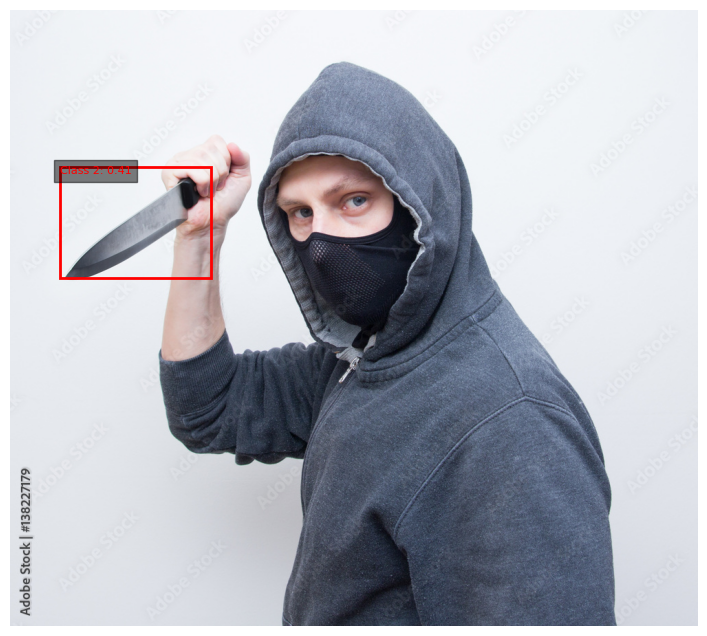

In [6]:
show_img(img_path, boxes, scores, labels)